In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

import sys
sys.path.append('/content/drive/MyDrive/installs')

In [9]:

# THIS FILE READS QUANTUM ESPRESSO OUTPUT, TRAINS WITH IT AND CAN ALSO TEST THE RESULTING MODEL

# Some imports are not necessary but they have managed to stay around

import io
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

#import graphdot
#from graphdot import Graph
#from graphdot.graph.adjacency import AtomicAdjacency
#from graphdot.graph.reorder import rcm
#from graphdot.kernel.marginalized import MarginalizedGraphKernel # https://graphdot.readthedocs.io/en/latest/apidoc/graphdot.kernel.marginalized.html
#from graphdot.kernel.marginalized.starting_probability import Uniform
#from graphdot.model.gaussian_process import (
    #GaussianProcessRegressor,
    #LowRankApproximateGPR
#)
#from graphdot.kernel.fix import Normalization
#from graphdot.kernel.molecular import Tang2019MolecularKernel as MolecularKernel
#import graphdot.microkernel as uX
#import ase.io
#from graphdot.graph.adjacency.atomic import AtomicAdjacency
#from graphdot.graph.adjacency.euclidean import CompactBell

# for getting all file names into a list under a directory
#from os import listdir
# for getting file names that match certain pattern
#import glob
#import time
#from ase.io import read

In [ ]:
# Initialize data
dir = "/content/drive/MyDrive/QE_Fe/PBE/High-pressure/300gpa_5000K/"
gpr = GaussianProcessRegressor(
    # kernel is the covariance function of the gaussian process (GP)
    kernel=Normalization(MolecularKernel()),
    alpha=1e-4, # value added to the diagonal of the kernel matrix during fitting
    optimizer=True, # default optimizer of L-BFGS-B based on scipy.optimize.minimize
    normalize_y=True, # normalize the y values so taht the means and variance is 0 and 1, repsectively. Will be reversed when predicions are returned
)

# Read output files into a list of atoms objects
nfiles = range(1,6)    #just to read some of the steps on the Fe MD to have an input
atoms_list = []
for f in nfiles:
  atoms_list.extend(read(dir + 'fe' + str(f) + '.out', index=':', format='espresso-out')) # Change directory to where you have the MD files

# This reads Valeria's newer MD outputs across the phase diagram directly from their subdirectories inside HighTempFe
# directory = '/home/adrian/Documents/ML_MD/HighTempFe'
# for subdir, dirs, files in os.walk(directory):
#     for file in files:
#         atoms_list.extend(read(os.path.join(subdir, file), index=':', format='espresso-out'))
#         print(os.path.join(subdir, file))

graphs = [Graph.from_ase(a, adjacency=AtomicAdjacency(shape='compactbell3,2')) for a in atoms_list] # List of graphs from each atoms object. This is the learning input
energy_gt = [a.get_potential_energy() for a in atoms_list] # List of energies from each atoms object. This is what the learning target
data = pd.DataFrame(list(zip(graphs, energy_gt)), columns=['Graphs', 'Pot_Energy']) # Dataframe with all necessary data for training
print(data)

                                                Graphs     Pot_Energy
0    Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573055.051661
1    Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573054.647459
2    Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573053.462388
3    Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573051.454258
4    Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573048.767039
..                                                 ...            ...
195  Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573012.671633
196  Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573011.956509
197  Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573011.348628
198  Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573010.912138
199  Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573010.654542

[200 rows x 2 columns]


In [ ]:
# Creating datasets

ntsteps = len(atoms_list)
target = 'Pot_Energy' # Learning target from the dataframe
N_test = ntsteps//3 # Number of testing steps
N_train = ntsteps # For when I do not care about testing and want the best possible model
# N_train = 2*N_test # Number of training steps
print(N_train)
print(N_test)
np.random.seed(0)
# select train and test data
train_sel = np.random.choice(ntsteps, N_train, replace=False)
test_sel = np.random.choice(ntsteps, N_test, replace=False)
train_data = data.iloc[train_sel]
test_data = data.iloc[test_sel]
print(train_data)

200
66
                                                Graphs     Pot_Energy
18   Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573010.093766
170  Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573003.847508
107  Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573018.919587
98   Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573017.388033
177  Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573010.924176
..                                                 ...            ...
67   Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -572989.065365
192  Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573015.538413
117  Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573007.967672
47   Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573011.913138
172  Graph(nodes={'!i': [  0,  1,  2,  3,  4,  5,  ... -573004.659236

[200 rows x 2 columns]


In [ ]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Training

start_time = time.time()
gpr = gpr.fit(train_data['Graphs'], train_data[target], repeat=1, verbose=True) # The training
end_time = time.time()
print("the total time consumption for " + str(N_train) + " steps is " + str(end_time - start_time) + "s.")

gpr.save(dir, filename='gpr_DFT_PotEng_3,2_'+str(N_train)+'.pkl') # Storing the model for future use

|        logP|       dlogP|     y^T.K.y|     log|K| |     Cond(K)|  GPU time|  CPU time|
|------------|------------|------------|------------|------------|----------|----------|
|       34569|   1.179e+05|       36312|     -1742.9|  2.0144e+06|   3.2e+02|    0.0067|
|       40632|  2.0324e+05|       42414|     -1782.3|  2.0199e+06|   3.7e+02|    0.0053|
|       33671|       53400|       35427|     -1756.5|  2.0162e+06|   3.6e+02|    0.0053|
|       33651|       52176|       35409|     -1758.2|  2.0153e+06|   3.6e+02|    0.0054|
|       33607|       52189|       35366|     -1759.3|  2.0176e+06|   3.6e+02|    0.0055|
|       33518|       53049|       35278|     -1760.7|  2.0158e+06|   3.6e+02|    0.0053|
|       33380|       53166|       35140|     -1760.8|  2.0184e+06|   3.6e+02|    0.0056|
|       33236|       51358|       34994|       -1758|  2.0122e+06|   3.6e+02|    0.0049|
|       33193|       51429|       34950|     -1757.3|  2.0147e+06|   3.6e+02|     0.005|
|       33181|       

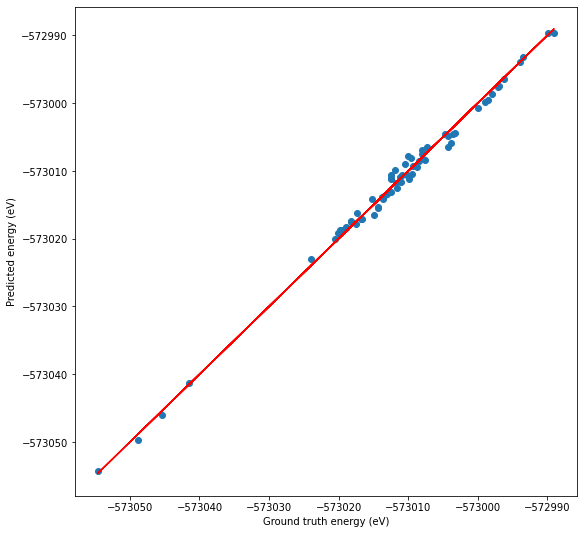

Test set
MAE: 0.7866006466845813
RMSE: 0.9436070608425741


In [ ]:
# Testing

gpr.load(dir, filename='gpr_DFT_PotEng_3,2_'+str(N_train)+'.pkl')
mu = gpr.predict(test_data['Graphs']) # The testing

# Plot ground truth v prediction
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot()
ax.scatter(test_data[target], mu)
ax.plot(test_data[target], test_data[target], '-r')
ax.ticklabel_format(style='plain', useOffset=False)
ax.set_xlabel('Ground truth energy (eV)')
ax.set_ylabel('Predicted energy (eV)')
plt.show()

print('Test set')
print('MAE:', np.mean(np.abs(test_data[target] - mu))) # Mean Absolute Error
print('RMSE:', np.std(test_data[target] - mu)) # Root Mean Square Error

0.9436113859469554


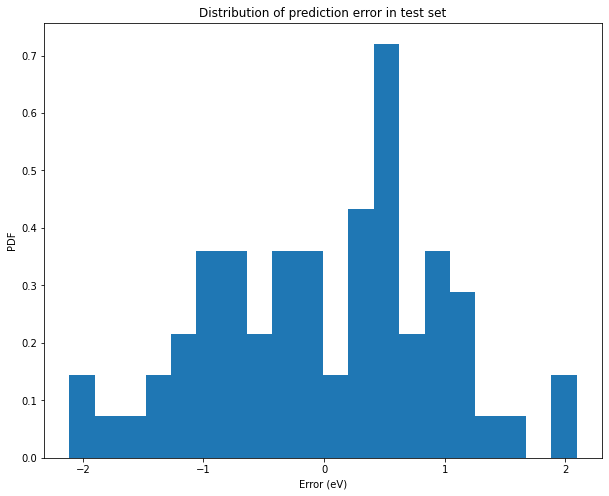

In [ ]:
# Error histogram

error = test_data[target] - mu
a, m, s = stats.skewnorm.fit(error)

# Plot the PDF
plt.figure(figsize=(10,8))
plt.title('Distribution of prediction error in test set')
plt.xlabel('Error (eV)')
plt.ylabel('PDF')
plt.hist(error, bins=20, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(-xmax, -xmin, 20)
p = stats.skewnorm.pdf(x, a, m, s)
# plt.plot(-x, p, 'k')
rmse = np.sqrt(np.mean(error**2))
print(rmse)